# Math 8803 HW1

## Problem 1 - Connor-Stevens Model


The main differential equation for the Connor-Stevens Model is:

$$I(t) = C (\frac{dV}{dt}) + g_{L}(V - E_{L}) + g_{Na}(V - E_{Na}) + g_{K}(V - E_{K}) + g_{A}(V - E_{K})$$

$$\frac{dV}{dt} = \frac{g_{L}(V - E_{L}) + g_{Na}(V - E_{Na}) + g_{K}(V - E_{K}) + g_{A}(V - E_{K}) - I(t)}{C}$$


#### Explanation of Parameters:

1. $C(\frac{dV}{dt})$ - We can think of the membrane as a capacitor and $V$ represents the voltage across the membrane. $C$ is capacitance or $C = \frac{q}{u} = \frac{q}{V}$ where $q$ is a charge and $v$ reprecents the voltage across a capacitor. Thus, $C(\frac{dV}{dt})$ is the charging current $I_{c}(t)$ that is applied on the membrane.

2. $E_{Na}$ - Battery Voltage for Sodium

3. $E_{K}$ - Battery Voltage for Potassium

4. $E_{L}$ - Battery Voltage for Unspecific Third Channel

5. $g_{Na} = \overline{g}_{Na} m^{3}h$ - Sodium Conductance. Here $\overline{g}_{Na}$ is a normalization constant, $m$ describes the activation/opening of the and $h$ describes the inactivation/blocking of the $Na^{+}$ channels.  

6. $g_{K} = \overline{g}_{k} n^{4}$ - Delayed Potassium Conductance, where $\overline{g}_{k}$ is a normalization constant and $n$ controls the $K^{+}$ gates. 

7. $g_{A} = \overline{g}_{A} A^{3}B$ - Transient Potassium Conductance, where $\overline{g}_{A}$ is a normalization factor, $A$ is an activation term, and $B$ is an inactivation term. 

8. $g_{L}$ - Leaky Battery Conductance

9. $V$ - Voltage across the cell membrane


In [3]:
import numpy as np 
from scipy.integrate import solve_ivp, odeint
from math import exp, pow, isclose
import matplotlib.pyplot as plt
from random import seed,random

### Version from Dayan and Abbott

In [52]:
2# Rate functions for m 
def alpha_m(V):
	# potential numerical instability
	x = (V + 29.7)
	return (0.38 * x) / (1.0 - np.exp(-0.1 * x))

def beta_m(V):
	return 15.2 * np.exp(-0.0556 * (V + 54.7))

def m_inf(V):
	return alpha_m(V) / (alpha_m(V) + beta_m(V))

def tau_m(V):
	return 1 / (alpha_m(V) + beta_m(V))

# Rate functions for h
def alpha_h(V):
	return 0.266 * np.exp(-0.05 * (V + 48))

def beta_h(V):
	return 3.8 / (1 + np.exp(-0.1 * (V + 18)))

def h_inf(V):
	return (alpha_h(V)) / (alpha_h(V) + beta_h(V))

def tau_h(V):
	return 1 / (alpha_h(V) + beta_h(V))

# Rate functions for n
def alpha_n(V):
	x = (V + 45.7)
	return (0.02 * x) / (1.0 - np.exp(-0.1 * x))

def beta_n(V):
	return 0.25 * np.exp(-0.0125 * (V + 55.7))

def n_inf(V):
	return alpha_n(V) / (alpha_n(V) + beta_n(V))

def tau_n(V):
	return 1 / (alpha_n(V) + beta_n(V))

# Rate functions for a
def a_inf(V):
	num = 0.0761 * np.exp(0.0314 * (V + 94.22))
	den = 1 + np.exp(0.0346 * (V + 1.17))
	return pow(num / den, 1 / 3.0)

def tau_a(V):
	den = 1 + np.exp(0.0497 * (V + 55.96))
	return 0.3632 + (1.158 / den)

# Rate functiosn for b
def b_inf(V):
	term = (1 / (1 + np.exp(0.0688 * (V + 53.3))))
	return pow(term, 4)

def tau_b(V):
	den = 1 + np.exp(0.0624 * (V + 50))
	return 1.24 + (2.678 / den) 


#### Define constants

1/cm^2 to 1/mm^2 Divide by 100

1/mm^2 to 1/cm^2 Multiply by 100

In [53]:
V0 = -68 # -68 mV

# All in mmho /cm^2
g_bar_na = 120 
g_bar_k = 20
g_bar_a = 47.7

# All in mV
E_na = 55
E_k = -72
E_l = -17
E_a = -75

# Capacitance and Leaky Conductance
Cm = 1 # microFarad/cm^2
g_l = 0.3 # mmho/cm^2

x0 = [V0, m_inf(V0), h_inf(V0), n_inf(V0), a_inf(V0), b_inf(V0)]
T = np.linspace(0, 1500, 150000)

In [54]:
def ConnorStevens(x, t, i):
	V = x[0]
	m = x[1]
	h = x[2]
	n = x[3]
	a = x[4]
	b = x[5]

	I = 0

	if 1400 > t > 100:
		I = i

	dmdt = alpha_m(V) * (1 - m) - (beta_m(V) * m)
	dhdt = alpha_h(V) * (1 - h) - (beta_h(V) * h)
	dndt = alpha_n(V) * (1 - n) - (beta_n(V) * n)
	dadt = (a_inf(V) - a) / tau_a(V)
	dbdt = (b_inf(V) - b) / tau_b(V)

	dmdt2 = (m_inf(V) - m) / tau_m(V)
	dhdt2 = (h_inf(V) - h) / tau_h(V)
	dndt2 = (n_inf(V) - n) / tau_n(V)

	assert isclose(dmdt, dmdt2, abs_tol=1e-3) == True
	assert isclose(dhdt, dhdt2, abs_tol=1e-3) == True
	assert isclose(dndt, dndt2, abs_tol=1e-3) == True

	I_l = -g_l * (V - E_l)
	I_na = -g_bar_na * (pow(m, 3) * h) * (V - E_na)
	I_k = -g_bar_k * (pow(n, 4)) * (V - E_k)
	I_a = -g_bar_a * (pow(a, 3) * b) * (V - E_a)

	dvdt = (I + I_l + I_na + I_k + I_a) / Cm

	return [dvdt, dmdt, dhdt, dndt, dadt, dbdt]

In [55]:
x = odeint(ConnorStevens, x0, T, args=(9,))

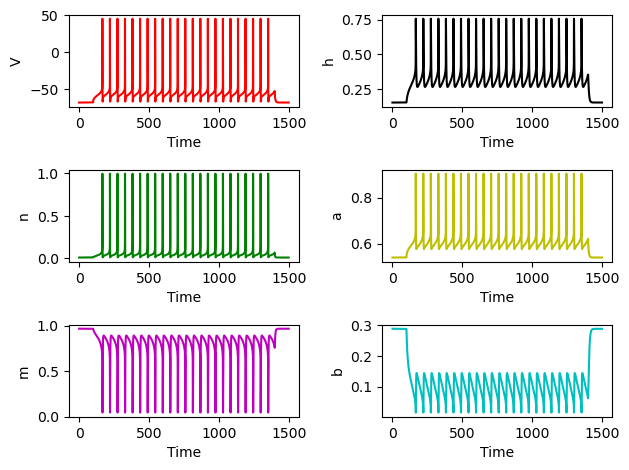

In [56]:
volt = x[:, 0]
n_part = x[:, 1]
m_part = x[:, 2]
h_part = x[:, 3]
a = x[:, 4]
b = x[:, 5]

fig, ax = plt.subplots(3, 2)
ax[0, 0].plot(T, volt, 'r')
ax[0, 0].set_xlabel("Time")
ax[0, 0].set_ylabel("V")

ax[1, 0].plot(T, n_part, 'g')
ax[1, 0].set_xlabel("Time")
ax[1, 0].set_ylabel("n")

ax[2, 0].plot(T, m_part, 'm')
ax[2, 0].set_xlabel("Time")
ax[2, 0].set_ylabel("m")

ax[0, 1].plot(T, h_part, 'k')
ax[0, 1].set_xlabel("Time")
ax[0, 1].set_ylabel("h")

ax[1, 1].plot(T, a, 'y')
ax[1, 1].set_xlabel("Time")
ax[1, 1].set_ylabel("a")

ax[2, 1].plot(T, b, 'c')
ax[2, 1].set_xlabel("Time")
ax[2, 1].set_ylabel("b")

plt.tight_layout()
plt.show()

<class 'numpy.ndarray'>


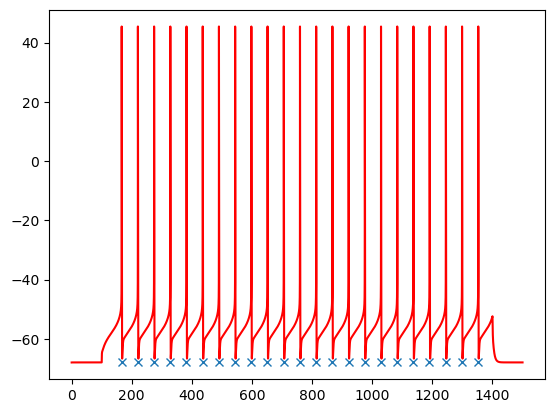

[ 166  220  274  328  382  436  490  543  597  651  705  759  813  867
  921  975 1029 1083 1137 1190 1244 1298 1352]


In [57]:
from scipy.signal import find_peaks
peaks, _ = find_peaks(volt, height=25)
peak_rounded = np.floor(peaks / 100.0).astype(int)
print(type(peak_rounded))
plt.plot(T, volt, 'r')
plt.plot(peak_rounded, volt[peak_rounded], "x")
plt.show()
print(peak_rounded)

In [58]:
diffs = np.ediff1d(peak_rounded)
avg = np.mean(diffs)
print(f"Frequency: {(1 / avg) * 1000} Hz")

Frequency: 18.54974704890388 Hz


In [61]:
injected_currents = [9, 10, 14, 16, 20, 50, 100]
firing_rate = []

for ic in injected_currents:
	x = odeint(ConnorStevens, x0, T, args=(ic,))
	volt = x[:, 0]
	peaks, _ = find_peaks(volt, height=25)
	peak_rounded = np.floor(peaks / 100.0).astype(int)
	diffs = np.ediff1d(peak_rounded)
	avg = np.mean(diffs[int(2 * len(diffs)/3): len(diffs)])
	firing_rate.append((1 / avg) * 1000)


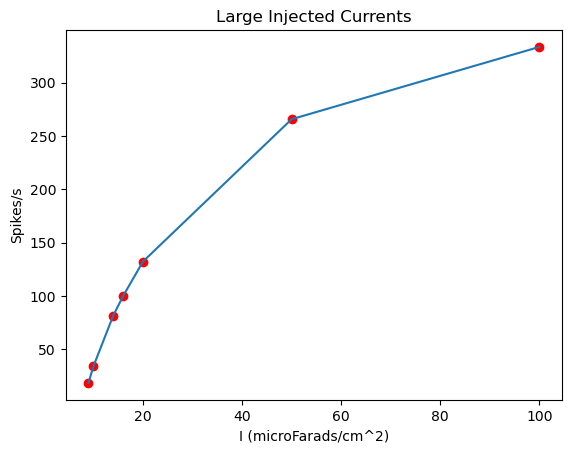

In [62]:
plt.plot(injected_currents, firing_rate)
plt.scatter(injected_currents, firing_rate, c="r")
plt.title("Large Injected Currents")
plt.xlabel("I (microFarads/cm^2)")
plt.ylabel("Spikes/s")
plt.show()

In [63]:
injected_currents = [8.1, 8.15, 8.2, 8.4, 8.75, 9, 9.25, 9.5, 10]
firing_rate = []

for ic in injected_currents:
	x = odeint(ConnorStevens, x0, T, args=(ic,))
	volt = x[:, 0]
	peaks, _ = find_peaks(volt, height=25)
	peak_rounded = np.floor(peaks / 100.0).astype(int)
	diffs = np.ediff1d(peak_rounded)
	avg = np.mean(diffs[int(2 * len(diffs)/3):len(diffs)])
	firing_rate.append((1 / avg) * 1000)


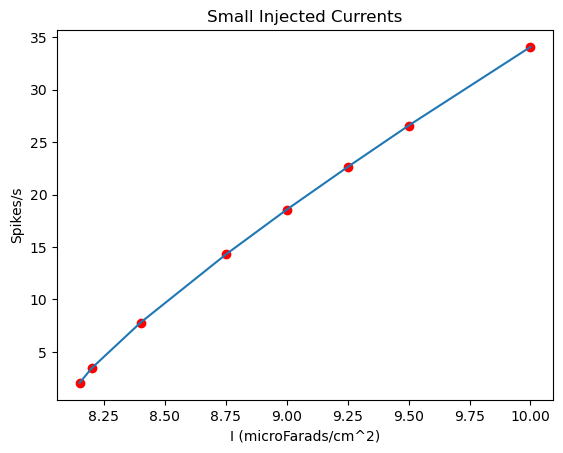

In [64]:
plt.plot(injected_currents, firing_rate)
plt.scatter(injected_currents, firing_rate, c="r")
plt.title("Small Injected Currents")
plt.xlabel("I (microFarads/cm^2)")
plt.ylabel("Spikes/s")
plt.show()

#### Model From Original Paper

In [31]:
MSHFT = -5.3
HSHFT = -12
NSHFT = -4.3

# Rate functions for m
def alpha_m_og(V):
	num = -0.1 * (V + 35 + MSHFT)
	den = np.exp((-(V + 35 + MSHFT) / 10)) - 1
	return num / den

def beta_m_og(V):
	return 4 * np.exp(-(V + 60 + MSHFT) / 18)

def m_inf_og(V):
	return alpha_m_og(V) / (alpha_m_og(V) + beta_m_og(V))

def tau_m_og(V):
	return 1 / (3.8 * (alpha_m_og(V) + beta_m_og(V))) # Correct?

# Rate functions for h
def alpha_h_og(V):
	return 0.07 * np.exp(-(V + 60 + HSHFT) / 20)

def beta_h_og(V):
	return 1 / (np.exp(-(V + 30 + HSHFT) / 10) + 1)

def h_inf_og(V):
	return (alpha_h_og(V)) / (alpha_h_og(V) + beta_h_og(V))

def tau_h_og(V):
	return 1 / (3.8  * (alpha_h_og(V) + beta_h_og(V)))

# Rate functions for n
def alpha_n_og(V):
	num = -0.01 * (V + 50 + NSHFT)
	den = np.exp((-(V + 50 + NSHFT) / 10)) - 1	
	return num / den

def beta_n_og(V):
	return 0.125 * np.exp(-(V + 60 + NSHFT)/ 80)

def n_inf_og(V):
	return alpha_n_og(V) / (alpha_n_og(V) + beta_n_og(V))

def tau_n_og(V):
	return 2 / (3.8 * (alpha_n_og(V) + beta_n_og(V)))

# Rate functions for a
def a_inf_og(V):
	num = 0.0761 * np.exp((V + 94.22) / 31.84)
	den = 1 + np.exp((V + 1.17) / 28.93)
	return pow(num / den, 1 / 3.0)

def tau_a_og(V):
	den = 1 + np.exp((V + 55.96) / 20.12)
	return 0.3632 + (1.158 / den)

# Rate functiosn for b
def b_inf_og(V):
	den =  pow(1 + np.exp((V + 53.3) / 14.54), 4)
	return 1 / den

def tau_b_og(V):
	den = 1 + np.exp((V + 50) / 16.027)
	return 1.24 + (2.678 / den) 

In [65]:
V0 = -68 # -68 mV

# All in mmho /cm^2
g_bar_na = 120 
g_bar_k = 20
g_bar_a = 47.7

# All in mV
E_na = 55
E_k = -72
E_l = -17
E_a = -75

# Capacitance and Leaky Conductance
Cm = 1 # microFarad/cm^2
g_l = 0.3 # mmho/cm^2

x0 = [V0, m_inf_og(V0), h_inf_og(V0), n_inf_og(V0), a_inf_og(V0), b_inf_og(V0)]
T = np.linspace(0, 1500, 150000)

In [66]:
def ConnorStevens_og1(x, t, i):
	V = x[0]
	m = x[1]
	h = x[2]
	n = x[3]
	a = x[4]
	b = x[5]

	I = 0

	if 1400 > t > 100:
		I = i

	dmdt = alpha_m_og(V) * (1 - m) - (beta_m_og(V) * m)
	dhdt = alpha_h_og(V) * (1 - h) - (beta_h_og(V) * h)
	dndt = alpha_n_og(V) * (1 - n) - (beta_n_og(V) * n)
	dadt = (a_inf_og(V) - a) / tau_a_og(V)
	dbdt = (b_inf_og(V) - b) / tau_b_og(V)

	I_l = -g_l * (V - E_l)
	I_na = -g_bar_na * (pow(m, 3) * h) * (V - E_na)
	I_k = -g_bar_k * (pow(n, 4)) * (V - E_k)
	I_a = -g_bar_a * (pow(a, 3) * b) * (V - E_a)

	dvdt = (I + I_l + I_na + I_k + I_a) / Cm

	return [dvdt, dmdt, dhdt, dndt, dadt, dbdt]

def ConnorStevens_og2(x, t, i):
	V = x[0]
	m = x[1]
	h = x[2]
	n = x[3]
	a = x[4]
	b = x[5]

	I = 0

	if 1400 > t > 100:
		I = i

	dmdt2 = (m_inf_og(V) - m) / tau_m_og(V)
	dhdt2 = (h_inf_og(V) - h) / tau_h_og(V)
	dndt2 = (n_inf_og(V) - n) / tau_n_og(V)
	dadt2 = (a_inf_og(V) - a) / tau_a_og(V)
	dbdt2 = (b_inf_og(V) - b) / tau_b_og(V)

	I_l = -g_l * (V - E_l)
	I_na = -g_bar_na * (pow(m, 3) * h) * (V - E_na)
	I_k = -g_bar_k * (pow(n, 4)) * (V - E_k)
	I_a = -g_bar_a * (pow(a, 3) * b) * (V - E_a)

	dvdt = (I + I_l + I_na + I_k + I_a) / Cm

	return [dvdt, dmdt2, dhdt2, dndt2, dadt2, dbdt2]

In [67]:
x1 = odeint(ConnorStevens_og1, x0, T, args=(9,))
x2 = odeint(ConnorStevens_og2, x0, T, args=(9,))

In [68]:
def plot(x):
	volt = x[:, 0]
	n_part = x[:, 1]
	m_part = x[:, 2]
	h_part = x[:, 3]
	a = x[:, 4]
	b = x[:, 5]

	fig, ax = plt.subplots(3, 2)
	ax[0, 0].plot(T, volt, 'r')
	ax[0, 0].set_xlabel("Time (ms)")
	ax[0, 0].set_ylabel("V")

	ax[1, 0].plot(T, n_part, 'g')
	ax[1, 0].set_xlabel("Time (ms)")
	ax[1, 0].set_ylabel("n")

	ax[2, 0].plot(T, m_part, 'm')
	ax[2, 0].set_xlabel("Time (ms)")
	ax[2, 0].set_ylabel("m")

	ax[0, 1].plot(T, h_part, 'k')
	ax[0, 1].set_xlabel("Time (ms)")
	ax[0, 1].set_ylabel("h")

	ax[1, 1].plot(T, a, 'y')
	ax[1, 1].set_xlabel("Time (ms)")
	ax[1, 1].set_ylabel("a")

	ax[2, 1].plot(T, b, 'c')
	ax[2, 1].set_xlabel("Time (ms)")
	ax[2, 1].set_ylabel("b")

	plt.tight_layout()
	plt.show()

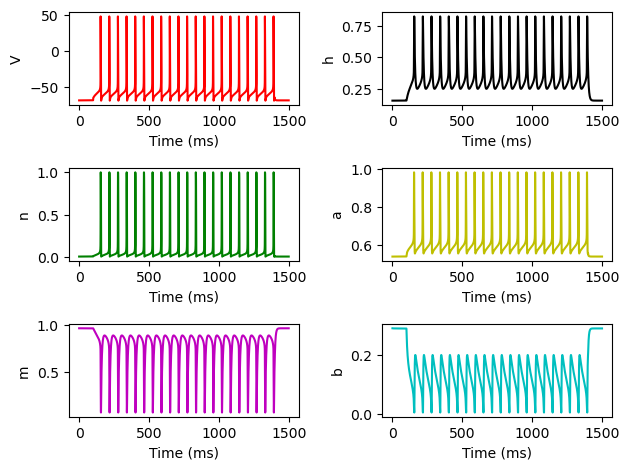

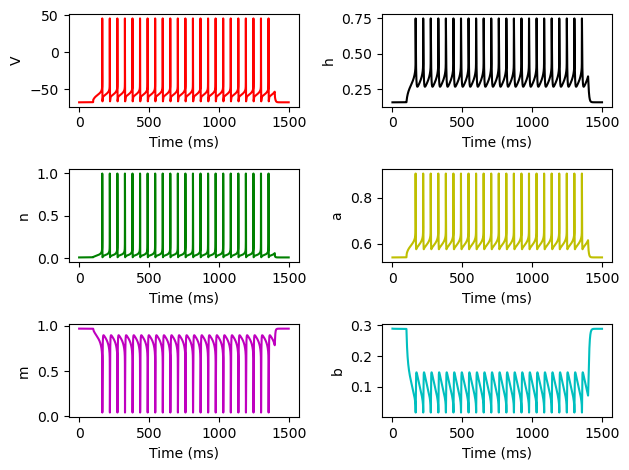

In [69]:
plot(x1)
plot(x2)

In [77]:
injected_currents = [9, 10, 14, 16, 20, 50, 100]
firing_rate = []

for ic in injected_currents:
	x = odeint(ConnorStevens_og2, x0, T, args=(ic,))
	volt = x[:, 0]
	peaks, _ = find_peaks(volt, height=25)
	peak_rounded = np.floor(peaks / 100.0).astype(int)
	diffs = np.ediff1d(peak_rounded)
	avg = np.mean(diffs[int(2 * len(diffs)/3): len(diffs)])
	firing_rate.append((1 / avg) * 1000)


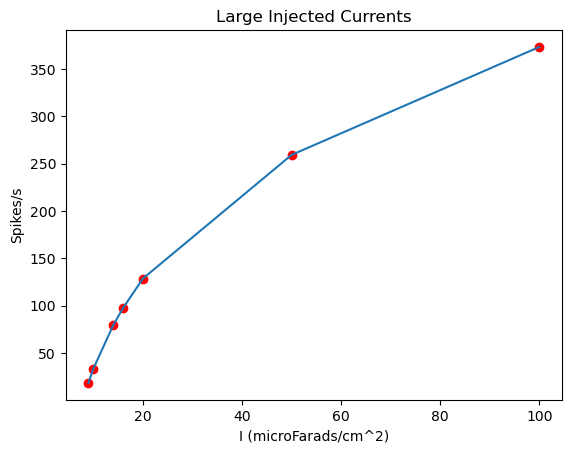

In [79]:
plt.plot(injected_currents, firing_rate)
plt.scatter(injected_currents, firing_rate, c="r")
plt.title("Large Injected Currents")
plt.xlabel("I (microFarads/cm^2)")
plt.ylabel("Spikes/s")
plt.show()

In [72]:
injected_currents = [8.1, 8.15, 8.2, 8.4, 8.75, 9, 9.25, 9.5, 10]
firing_rate = []

for ic in injected_currents:
	x = odeint(ConnorStevens_og1, x0, T, args=(ic,))
	volt = x[:, 0]
	peaks, _ = find_peaks(volt, height=25)
	peak_rounded = np.floor(peaks / 100.0).astype(int)
	diffs = np.ediff1d(peak_rounded)
	avg = np.mean(diffs[int(2 * len(diffs)/3):len(diffs)])
	firing_rate.append((1 / avg) * 1000)


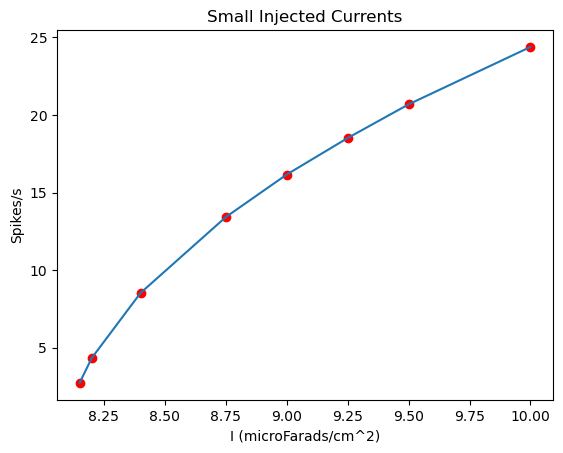

In [73]:
plt.plot(injected_currents, firing_rate)
plt.scatter(injected_currents, firing_rate, c="r")
plt.title("Small Injected Currents")
plt.xlabel("I (microFarads/cm^2)")
plt.ylabel("Spikes/s")
plt.show()

## Problem 2 - Izhekevich Model

### Resonator Scenario

In [41]:
a = 0.1
b = 0.26
c= -60
d= -1
timestep = 0.25
voltage_threshold = 30

T = np.arange(0, 400 + timestep, timestep)
I = np.zeros(len(T))
v = np.zeros(len(T))
u = np.zeros(len(T))

v[0] = -62
u[0] = b * v[0]

T1 = T[-1] / 10
T2 = T1 + 20
T3 = 0.7 * T[-1]
T4 = T3 + 40

1601
40.0 60.0 280.0 320.0
[0.0000e+00 2.5000e-01 5.0000e-01 ... 3.9950e+02 3.9975e+02 4.0000e+02]


In [46]:
V = -62
U = b * V

for i in range(1, len(T)):
	t = T[i]     
	if ((t > T1) and (t < T1 + 4)) or ((t > T2) and (t < T2 + 4)) or ((t > T3) and (t < T3 + 4)) or ((t > T4) and (t < T4 + 4)):
		Ic = 0.65
	else:
		Ic = 0
	V = V + timestep * (0.04 * pow(V, 2) + 5*V + 140 - U + Ic)
	U = U + timestep * (a*(b*V-U))
	I[i] = Ic
	if (V >= voltage_threshold):
		v[i] = 30
		V = c
		U = U + d
	else:
		v[i] = V
	u[i] = U

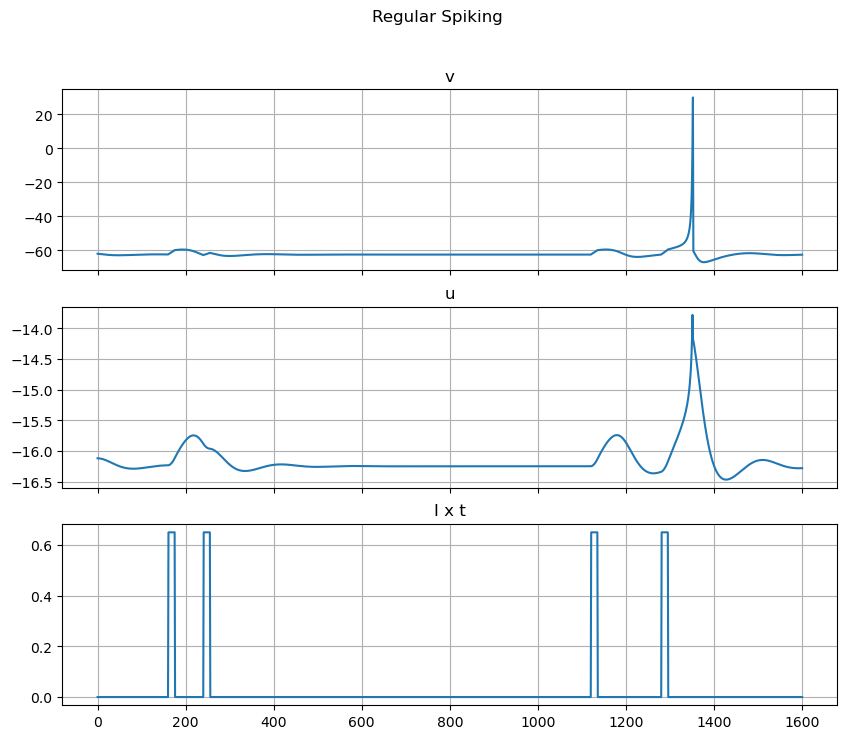

In [47]:
fig, axs = plt.subplots(3, sharex=True, figsize=(10,8))
fig.suptitle("Regular Spiking")
axs[0].plot(v)
axs[0].set_title('v')
axs[0].grid()

axs[1].plot(u)
axs[1].set_title('u')
axs[1].grid()

axs[2].plot(I)
axs[2].set_title('I x t')
axs[2].grid()

### Integrator Scenario

In [48]:
a = 0.02
b = -0.1
c= -55
d= 6
timestep = 0.25
voltage_threshold = 30

T = np.arange(0, 100, timestep)
I = np.zeros(len(T))
v = np.zeros(len(T))
u = np.zeros(len(T))

v[0] = -60
u[0] = b * v[0]

T1 = T[-1] / 11
T2 = T1 + 5
T3 = 0.7 * T[-1]
T4 = T3 + 10

400
9.068181818181818 14.068181818181818 69.82499999999999 79.82499999999999


In [51]:
V = -60
U = b * V

for i in range(1, len(T)):
	t = T[i]
	if ((t > T1) and (t < T1 + 2)) or ((t > T2) and (t < T2 + 2)) or ((t > T3) and (t < T3 + 2)) or ((t > T4) and (t < T4 + 2)):
		Ic = 9
	else:
		Ic = 0
	V = V + timestep * (0.04 * V**2 + 4.1*V + 108 - U + Ic)
	U = U + timestep * a*(b*V-U)
	I[i] = Ic
	if (V > voltage_threshold):
		v[i] = 30
		V = c
		U = U + d
		print(t, "Spiked")
	else:
		v[i] = V
	u[i] = U

20.0 Spiked


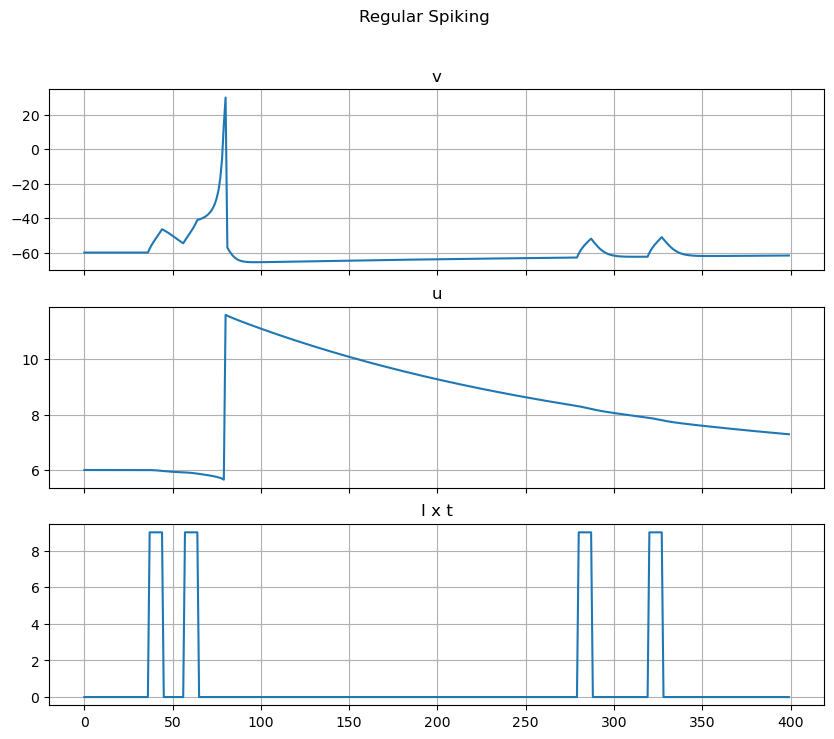

In [52]:
fig, axs = plt.subplots(3, sharex=True, figsize=(10,8))
fig.suptitle("Regular Spiking")
axs[0].plot(v)
axs[0].set_title('v')
axs[0].grid()

axs[1].plot(u)
axs[1].set_title('u')
axs[1].grid()

axs[2].plot(I)
axs[2].set_title('I x t')
axs[2].grid()

### Part (a)

In the absence of stimulus, the Izhikevich model in the integrator scenario looks like:

$$\frac{dv}{dt} = 0.04v^{2} + 4.1v + 108 - u$$

$$\frac{du}{dt} = a(bv - u)$$

where $a = 0.02$, $b = -0.1$, $c = -55$, and $d = 6$.  

and in the resonator scenario:

$$\frac{dv}{dt} = 0.04v^{2} + 5v + 140 - u$$

$$\frac{du}{dt} = a(bv - u)$$

where $a = 0.1$, $b = 0.26$, $c = -60$, and $d = -1$.  




#### Integrator Scenario FPs 

In the integrator scenario, we can get the fixed points by solving the system of equations:

$$0.04v^{2} + 4.1v + 108 - u = 0$$

$$a(bv - u) = 0$$

For the second equation, since $a \neq 0$ in all scenarios this implies that $bv - u = 0$, which means that $bv = u$. Substituting this into the first equation we get:

$$0.04v^{2} + 4.1v - bv = -108$$

$$0.04v^{2} + 4.2v + 108 = 0$$

And the roots of the equation are when $v = -60$ and $v = -45$. Thus the fixed points (in $(v, u)$ form) are $(-60, 6)$ and $(-45, 4.5)$ 

The Jacobian matrix for these points are in the form:

$$ 
\begin{pmatrix}
0.08v + 4.1 & -1\\
ab & -a
\end{pmatrix}
= 
\begin{pmatrix}
0.08v + 4.1 & -1\\
-0.002 & -0.02
\end{pmatrix}
$$

For the fixed point $(-60, 6)$ the Jacobian matrix's eigenvalues are $\lambda_{1} = \frac{1}{50} (-18 - 7\sqrt{6})$ and $\lambda_{2} = \frac{1}{50} (7\sqrt{6} - 18)$. Both $\lambda_{1}, \lambda_{2} < 0$, which means $(-60, 6)$ is a fixed point. 

On the other hand, for the fixed point $(-45, 4.5)$ the Jacobian matrix's eigenvalues are $\lambda_{1} = \frac{1}{50} (12 + \sqrt{174})$ and $\lambda_{2} = \frac{1}{50}(12 - \sqrt{174})$. Since $\lambda_{1} > 0$, $(-45, 4.5)$ is unstable. 

### Resonator Scenario

For the resonator scenario we solve a similar set of equations:

$$0.04v^{2} + 5v + 140 - u = 0$$

$$a(bv - u) = 0$$

and get the roots of:

$$0.04v^{2} + 4.74v + 140 = 0$$

which are $v = -62.5, -56$

so the fixed points are $(-62.5, -16.25)$ and $(-56, -14.56)$.

The Jacobian matrix can be written in the form:

$$ 
\begin{pmatrix}
0.08v + 5 & -1\\
ab & -a
\end{pmatrix}
= 
\begin{pmatrix}
0.08v + 5 & -1\\
0.026 & -0.1
\end{pmatrix}
$$

For the fixed point $(-62.5, -16.25)$, the Jacobian matrix's eigenvalues are $\lambda_{1} = \frac{1}{100} (-5 + i\sqrt{235})$ and $\lambda_{2} = \frac{1}{100}(-5 - i\sqrt{235})$. Since both $Re(\lambda_{1}), Re(\lambda_{2}) < 0$ this means that $(-62.5, -16.25)$ is a stable fixed point.

On the other hand, for the fixed point $(-45, 4.5)$ the Jacobian matrix's eigenvalues are $\lambda_{1} = \frac{1}{50}(-9 - \sqrt{105})$ and $\lambda_{2} = \frac{1}{50}(\sqrt{105} - 9)$. Since $\lambda_{2} > 0$, $(-45, -4.5)$ is unstable.

### Part (b) - Integrator Scenario

Here we set our initial condition as $v = -60$ and $u = 6$. We also set experiment duration to 100 ms and timesteps of .1 ms. Assuming T = 0.2 is in ms then the current is injected for ~20 ticks.

In [63]:
a = 0.02
b = -0.1
c = -55
d = 6
timestep = 0.1
voltage_threshold = 30
maxtime = 100

curr_start_time_ticks = 50
curr_end_time_ticks = curr_start_time_ticks + 2.1

62.400000000000006 0 10.82 Spiked


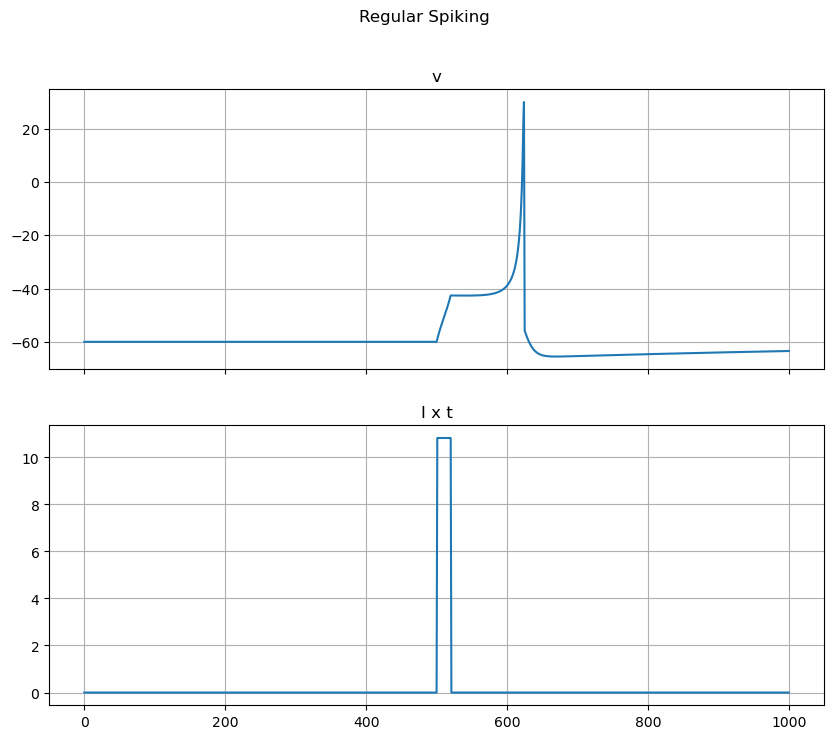

In [64]:
Iths = np.arange(0, 20, 0.01)
for Ith in Iths:
	T = np.arange(0, maxtime + timestep, timestep)
	I = np.zeros(len(T))
	v = np.zeros(len(T))
	u = np.zeros(len(T))
	spiked = False

	v[0] = -60
	u[0] = 6
	V = v[0]
	U = u[0]

	for i in range(1, len(T)):
		t = T[i]
		if  t > curr_start_time_ticks and t < curr_end_time_ticks:
			Ic = Ith
		else:
			Ic = 0
		V = V + timestep * (0.04 * V**2 + 4.1*V + 108 - U + Ic)
		U = U + timestep * a*(b*V-U)
		I[i] = Ic
		if (V > voltage_threshold):
			v[i] = 30
			V = c
			U = U + d
			print(t, Ic, Ith, "Spiked")
			spiked = True
		else:
			v[i] = V
		u[i] = U

	if spiked: 
		fig, axs = plt.subplots(2, sharex=True, figsize=(10,8))
		fig.suptitle("Regular Spiking")
		axs[0].plot(v)
		axs[0].set_title('v')
		axs[0].grid()

		axs[1].plot(I)
		axs[1].set_title('I x t')
		axs[1].grid()
		break

Based on above, the minimum current $I_{th}$ is roughly $10.82 (\mu A/cm^{2})$

In [54]:
Ith = 10.82
deltaTs = np.arange(0.1, 4, 0.1)
deltaT_spikes = []
timestep = 0.1
voltage_threshold = 30
maxtime = 100

firstpulse_start = maxtime // 5
firstpulse_end = firstpulse_start + 2.1

In [66]:
for deltaT in deltaTs:
	T = np.arange(0, maxtime + timestep, timestep)
	I = np.zeros(len(T))
	v = np.zeros(len(T))
	u = np.zeros(len(T))
	v[0] = -60
	u[0] = 6

	V = v[0]
	U = u[0]

	spiked = False
	secondpulse_start = firstpulse_end + deltaT
	secondpulse_end = secondpulse_start + 2.1


	for i in range(1, len(T)):
		t = T[i]
		if (t > firstpulse_start and t < firstpulse_end) or (t > secondpulse_start and t < secondpulse_end): # inject two pulses each for 0.02 ms
			Ic  = 0.8 * Ith
		else:
			Ic = 0
		V = V + timestep * (0.04 * V**2 + 4.1*V + 108 - U + Ic)
		U = U + timestep * a*(b*V-U)
		I[i] = Ic
		if (V > voltage_threshold):
			v[i] = 30
			V = c
			U = U + d
			spiked = True
			deltaT_spikes.append(deltaT)
		else:
			v[i] = V
		u[i] = U

	if spiked:
		print(deltaT, firstpulse_start, firstpulse_end, secondpulse_start, secondpulse_end)
		'''
		fig, axs = plt.subplots(2, sharex=True, figsize=(10,8))
		fig.suptitle(f"Spiking {deltaT}")
		axs[0].plot(v)
		axs[0].set_title('v')
		axs[0].grid()

		axs[1].plot(I)
		axs[1].set_title('I x t')
		axs[1].grid()
		'''
	else:
		print("Stopped at:", deltaT)
		break

0.1 20 22.1 22.200000000000003 24.300000000000004
0.2 20 22.1 22.3 24.400000000000002
0.30000000000000004 20 22.1 22.400000000000002 24.500000000000004
0.4 20 22.1 22.5 24.6
0.5 20 22.1 22.6 24.700000000000003
0.6 20 22.1 22.700000000000003 24.800000000000004
0.7000000000000001 20 22.1 22.8 24.900000000000002
0.8 20 22.1 22.900000000000002 25.000000000000004
0.9 20 22.1 23.0 25.1
1.0 20 22.1 23.1 25.200000000000003
1.1 20 22.1 23.200000000000003 25.300000000000004
1.2000000000000002 20 22.1 23.3 25.400000000000002
1.3000000000000003 20 22.1 23.400000000000002 25.500000000000004
1.4000000000000001 20 22.1 23.5 25.6
1.5000000000000002 20 22.1 23.6 25.700000000000003
1.6 20 22.1 23.700000000000003 25.800000000000004
1.7000000000000002 20 22.1 23.8 25.900000000000002
1.8000000000000003 20 22.1 23.900000000000002 26.000000000000004
1.9000000000000001 20 22.1 24.0 26.1
2.0 20 22.1 24.1 26.200000000000003
2.1 20 22.1 24.200000000000003 26.300000000000004
2.2 20 22.1 24.3 26.400000000000002
2.

Based on this time resolution 1 tick per $0.1$ ms the range of $\Delta(T)$ of the double-pulses leading to a spike is $0.1 \leq \Delta(T) < 2.9$.

### Part (c) Resonator Scenario

Here we set our initial condition as $(-62.5, -16.25)$ and we set the experiment duration to 300 ms and timesteps of .1 ms. Assuming T = 0.2 ms the current is injected for around ~20 ticks.

In [57]:
a = 0.1
b = 0.26
c= -60
d= -1
timestep = 0.1
voltage_threshold = 30
maxtime = 100

curr_start_time_ticks = 50
curr_end_time_ticks = curr_start_time_ticks + 2.1

80.9 0 1.29 Spiked


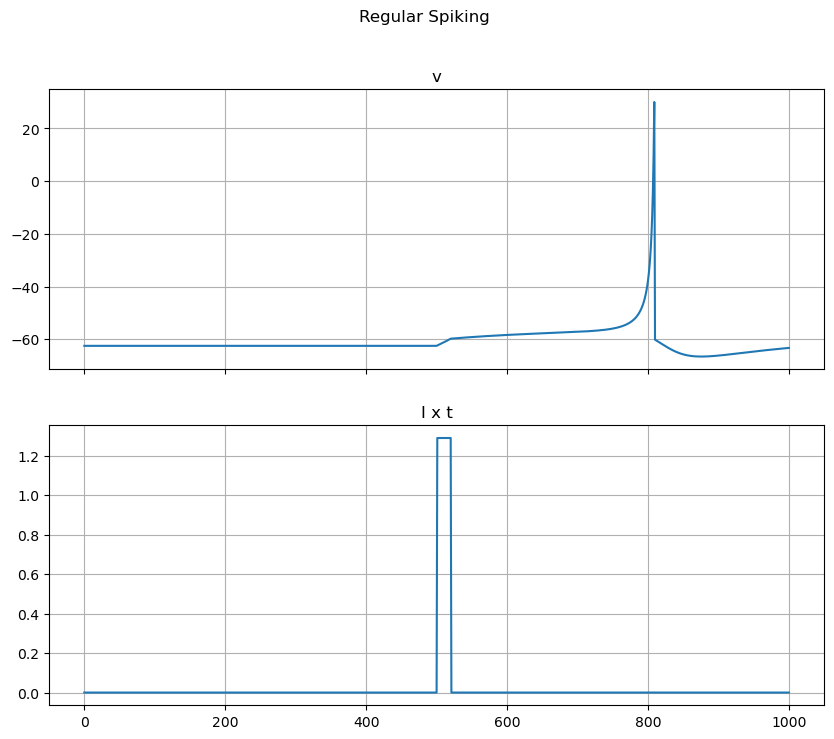

In [61]:
Iths = np.arange(0, 2, 0.01)
for Ith in Iths:
	T = np.arange(0, maxtime + timestep, timestep)
	I = np.zeros(len(T))
	v = np.zeros(len(T))
	u = np.zeros(len(T))
	spiked = False

	v[0] = -62.5
	u[0] = -16.25
	V = v[0]
	U = u[0]

	for i in range(1, len(T)):
		t = T[i]
		if  t > curr_start_time_ticks and t < curr_end_time_ticks:
			Ic = Ith
		else:
			Ic = 0
		V = V + timestep * (0.04 * V**2 + 5*V + 140 - U + Ic)
		U = U + timestep * a*(b*V-U)
		I[i] = Ic
		if (V > voltage_threshold):
			v[i] = 30
			V = c
			U = U + d
			print(t, Ic, Ith, "Spiked")
			spiked = True
		else:
			v[i] = V
		u[i] = U

	if spiked: 
		fig, axs = plt.subplots(2, sharex=True, figsize=(10,8))
		fig.suptitle("Regular Spiking")
		axs[0].plot(v)
		axs[0].set_title('v')
		axs[0].grid()

		axs[1].plot(I)
		axs[1].set_title('I x t')
		axs[1].grid()
		break

Based on the above, the minimum current $I_{th}$ is roughly $1.29 (\mu A/cm^{2})$

In [88]:
a = 0.1
b = 0.26
c= -60
d= -1

Ith = 1.29
deltaTs = np.arange(0, 111, 1)
deltaT_spikes = []
timestep = 0.1
voltage_threshold = 30
maxtime = 300

firstpulse_start = maxtime // 5
firstpulse_end = firstpulse_start + 2.1

In [89]:
for deltaT in deltaTs:
	T = np.arange(0, maxtime + timestep, timestep)
	I = np.zeros(len(T))
	v = np.zeros(len(T))
	u = np.zeros(len(T))
	v[0] = -62.5
	u[0] = -16.25

	V = v[0]
	U = u[0]

	spiked = False
	secondpulse_start = firstpulse_end + deltaT
	secondpulse_end = secondpulse_start + 2.1


	for i in range(1, len(T)):
		t = T[i]
		if (t > firstpulse_start and t < firstpulse_end) or (t > secondpulse_start and t < secondpulse_end): # inject two pulses each for 0.02 ms
			Ic  = 0.9 * Ith
		else:
			Ic = 0
		V = V + timestep * (0.04 * V**2 + 5*V + 140 - U + Ic)
		U = U + timestep * a*(b*V-U)
		I[i] = Ic
		if (V > voltage_threshold):
			v[i] = 30
			V = c
			U = U + d
			deltaT_spikes.append(deltaT)
		else:
			v[i] = V
		u[i] = U
print(deltaT_spikes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


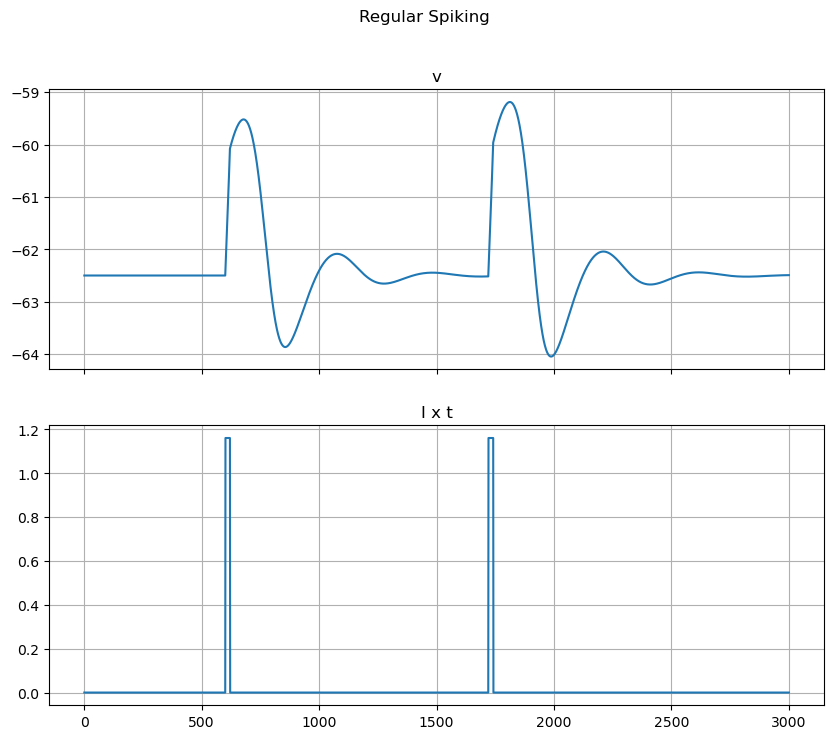

In [90]:
fig, axs = plt.subplots(2, sharex=True, figsize=(10,8))
fig.suptitle("Regular Spiking")
axs[0].plot(v)
axs[0].set_title('v')
axs[0].grid()

axs[1].plot(I)
axs[1].set_title('I x t')
axs[1].grid()

It seems that when $0 \leq \Delta(T) \leq 11$ and $33 \leq \Delta(T) \leq 49$ for the simulation to spike.

In [91]:
deltaT_spikes = []
for deltaT in deltaTs:
	T = np.arange(0, maxtime + timestep, timestep)
	I = np.zeros(len(T))
	v = np.zeros(len(T))
	u = np.zeros(len(T))
	v[0] = -62.5
	u[0] = -16.25

	V = v[0]
	U = u[0]

	spiked = False
	secondpulse_start = firstpulse_end + deltaT
	secondpulse_end = secondpulse_start + 2.1


	for i in range(1, len(T)):
		t = T[i]
		if (t > firstpulse_start and t < firstpulse_end) or (t > secondpulse_start and t < secondpulse_end): # inject two pulses each for 0.02 ms
			Ic  = 0.98 * Ith
		else:
			Ic = 0
		V = V + timestep * (0.04 * V**2 + 5*V + 140 - U + Ic)
		U = U + timestep * a*(b*V-U)
		I[i] = Ic
		if (V > voltage_threshold):
			v[i] = 30
			V = c
			U = U + d
			deltaT_spikes.append(deltaT)
		else:
			v[i] = V
		u[i] = U
print(deltaT_spikes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110]


When the injected current is $0.98I_{th}$ It seems that for $\Delta(T) \in [0, 16] \cup [36, 58] \cup [80, 110]$ the simulation spikes, which means that there are more double-pulse time difference values that will create spikes.

### Part (d)



For the integrator model, it seems that high frequency double-pulses are most likely to trigger a spike. When the distance between the two pulses gets lower, the voltage across the membrane only changes slightly and doesn't spike. Also it seems that the voltage doesn't oscillate at all for these type of neurons below their voltage thresholds. 

For the resonator model it seems that high frequency double-pulses and certain ranges of low frequency also trigger spikes. Also, by increasing the injected current, there are more ranges of low frequency double-pulses which also induce spiking. In other words, it seems that there is resonance of the frequency of current pulses with the frequency of spiking. 

## Problem 3 - Saddle-Node Bifurcation Differential Equation

Using the transformation $z(t) = \tan(\frac{\phi(t)}{2})$, first we differentiate by $t$ to get:

$$\frac{dz}{dt} = \sec^{2}(\frac{\phi(t)}{2}) * \frac{1}{2} * \frac{d \phi}{dt}$$


Plugging this into the "normal form" of the saddle-node bifurcation we get:

$$ \sec^{2}(\frac{\phi(t)}{2}) * \frac{1}{2} * \frac{d \phi}{dt} = \tan^{2}(\frac{\phi(t)}{2}) + I - I_{c}$$

$$ \frac{d \phi}{dt} = \sin^{2}(\frac{\phi(t)}{2}) + (I - I_{c})\cos^{2}(\frac{\phi(t)}{2})$$

$$ \frac{d \phi}{dt} = \sin^{2}(\frac{\phi(t)}{2}) + (I - I_{c})\cos^{2}(\frac{\phi(t)}{2})$$

By the half-angle identity:

$$ \frac{d \phi}{dt} = (1 - (\frac{1 + \cos(\phi(t))}{2})) + (I - I_{c})(\frac{1 + \cos(\phi(t))}{2})$$

In [49]:
x0 = 0
T = np.linspace(0, 1000, 1000)

In [50]:
def phase_eq(x, t, i):
	phi = x
	Ic = 100

	a = (1 + np.cos(phi)) / 2

	dphidt = (1 - a) + (i - Ic) * (a)
	return dphidt

In [57]:
freq = []
ij_c = [80, 90, 100, 101, 102, 103, 104, 105, 110, 120, 130, 140, 150, 160, 200, 300]
for i in ij_c:
	x = odeint(phase_eq, x0, T, args=(i,))
	freq.append(x[-1] / (2 * np.pi))

#### Reproduction of the Frequency vs Injected Current

The threshold value $100$ is arbitrary and unitless and we show what happens when the injected current is above and below the threshold value.

Text(0, 0.5, 'Frequency')

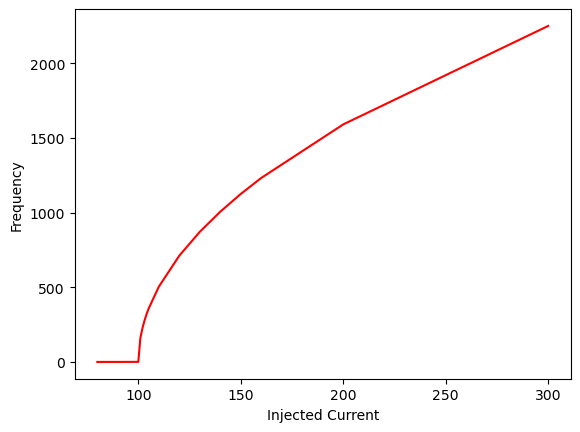

In [58]:
plt.plot(ij_c, freq, 'r')
plt.xlabel("Injected Current")
plt.ylabel("Frequency")